<a href="https://colab.research.google.com/github/LucaR45/Market-Basket-Analysis/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticating using the Kaggle API
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"

In [ ]:
# Install OpenJDK 8, required for Spark (based on website)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz

In [ ]:
# Install SpySpark
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [ ]:
import pandas as pd
import numpy as np
from itertools import product, combinations, chain

In [ ]:
# Download a dataset from Kaggle
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews --unzip --force

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
100% 1.06G/1.06G [00:11<00:00, 41.1MB/s]
100% 1.06G/1.06G [00:11<00:00, 103MB/s] 


In [ ]:
# Read CSV and display its contents
df = spark.read.csv("Books_rating.csv", header = True, sep=",")
df.show()

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| NULL| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
|0826414346|Dr. Seuss: Americ...| NULL|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
|0826414346|Dr. Seuss: Americ...| NULL|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|"If people become...|
|0826414346|Dr. Seuss: Ameri

In [ ]:
# Take a subset and convert it to rdd, considering just the column ""review/text"
sf = df.sample(False,0.001,seed = 21)
rdd = sf.rdd.map(lambda x: x[9])

In [ ]:
rdd.take(1)

['A great resource for paper type crafts. From paper mache to origami this book gives you projects you can follow right from the book or inspirations for your own creations. Clear instructions and excellent step by step photos. Tried some of the projects myself with success and had fun with the kids doing it. Great for a sunny day when you want to do something different or are stuck inside on a rainy day.']

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def clean_text(text):
    from nltk.corpus import stopwords
    if not text or isinstance(text, list):
        return ""
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return list(set(tokens))

In [ ]:
# Apply clena_text
rdd = rdd.map(clean_text)

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
rdd.take(1)

[['rainy',
  'success',
  'tried',
  'inside',
  'creation',
  'step',
  'fun',
  'want',
  'resource',
  'excellent',
  'day',
  'paper',
  'clear',
  'craft',
  'great',
  'follow',
  'book',
  'give',
  'right',
  'type',
  'inspiration',
  'something',
  'origami',
  'kid',
  'sunny',
  'stuck',
  'instruction',
  'project',
  'different',
  'mache',
  'photo']]

In [ ]:
#Create vocabulary assigning index to each word
def rdd_to_vocabulary(rdd):

    iw = rdd.flatMap(lambda line:line)\
                      .distinct().zipWithIndex()\
                      .map(lambda x: (x[1], x[0]))\
                      .collectAsMap()

    wi = {value:key for key, value in iw.items()}

    return iw, wi

iw, wi = rdd_to_vocabulary(rdd)

In [ ]:
# Substitute  word by index
def index_data(rdd, wi):
 return rdd.map(lambda sentence: [wi[word] for word in sentence])

rdd = index_data(rdd, wi)

In [ ]:
def create_combinations(items, i):
  items = items.map(lambda item: list(item[0]))
  singletons = items.flatMap(list)\
                    .map(lambda item:(item,1))\
                    .reduceByKey(lambda x,y: x+y)\
                    .map(lambda item:item[0])
  items_set = []

  for comb in list(product(items.toLocalIterator(), singletons.toLocalIterator())):
    comb = chain(comb[0], [comb[1]])
    comb_set = sorted(set().union(comb))
    if (len(comb_set) == i) and comb_set not in items_set:
        items_set.append(comb_set)
  return items_set

In [ ]:
def apriori(rdd, threshold):

  results = sc.parallelize([])

  singletons = rdd.flatMap(list)\
                  .map(lambda item: (item,1))\
                  .reduceByKey(lambda x,y: x+y)\
                  .filter(lambda item: item[1] >= threshold)

  results = results.union(singletons)

  singletons = singletons.map(lambda x: x[0])

  possible_pairs = list(combinations(singletons.toLocalIterator(),2))

  i=3

  while len(possible_pairs)>0:

    #check whether the possible items are frequent
    frequent_items = rdd.flatMap(lambda sentence: [(tuple(item), 1) for item in possible_pairs if set(list(item)).issubset(set(sentence))]) \
                    .reduceByKey(lambda x, y: x+y) \
                    .filter(lambda item: item[1] >= threshold)

    results = results.union(frequent_items)

    possible_pairs = create_combinations(frequent_items, i)

    i += 1

  return results

In [ ]:

count = rdd.count()
threshold = count*0.03
print(count, threshold)

2997 89.91


In [ ]:
results = apriori(rdd, threshold) #run apriori

In [ ]:
results = results.collect() #colelct resulta

In [ ]:
results

[(11374, 166),
 (17710, 115),
 (9306, 276),
 (21890, 97),
 (6204, 102),
 (12452, 289),
 (10362, 144),
 (15598, 137),
 (12474, 156),
 (16698, 128),
 (11418, 107),
 (13574, 102),
 (1100, 100),
 (4202, 95),
 (9307, 256),
 (13509, 471),
 (17711, 345),
 (3081, 314),
 (21891, 142),
 (8295, 156),
 (14543, 117),
 (4115, 103),
 (19823, 90),
 (13531, 96),
 (15621, 444),
 (7283, 100),
 (9351, 94),
 (15665, 91),
 (2048, 168),
 (17712, 1319),
 (13510, 200),
 (14544, 116),
 (1058, 119),
 (14566, 107),
 (12498, 100),
 (6250, 137),
 (90, 134),
 (20837, 370),
 (1037, 223),
 (21893, 206),
 (10365, 129),
 (8297, 273),
 (20859, 140),
 (21915, 108),
 (17735, 157),
 (12477, 91),
 (14567, 152),
 (21937, 99),
 (4161, 157),
 (8341, 134),
 (8276, 99),
 (20838, 224),
 (4, 733),
 (17714, 1291),
 (18770, 132),
 (8298, 237),
 (26, 347),
 (21916, 93),
 (10388, 159),
 (3128, 94),
 (11532, 100),
 (8277, 221),
 (2051, 225),
 (13513, 488),
 (11379, 186),
 (16659, 108),
 (17715, 969),
 (1039, 386),
 (7265, 112),
 (6209, 

In [ ]:
results = [(iw[t[0]],t[1]) if type(t[0])==int else (tuple([iw[element] for element in t[0]]),t[1]) for t in results]

In [ ]:
results

[('different', 166),
 ('job', 115),
 ('two', 276),
 ('beginning', 97),
 ('three', 102),
 ('found', 289),
 ('detail', 144),
 ('mind', 137),
 ('place', 156),
 ('worth', 128),
 ('came', 107),
 ('sure', 102),
 ('seem', 100),
 ('getting', 95),
 ('go', 256),
 ('character', 471),
 ('know', 345),
 ('quot', 314),
 ('enjoyed', 142),
 ('word', 156),
 ('nothing', 117),
 ('main', 103),
 ('pretty', 90),
 ('seen', 96),
 ('make', 444),
 ('second', 100),
 ('money', 94),
 ('girl', 91),
 ('friend', 168),
 ("'s", 1319),
 ('however', 200),
 ('writer', 116),
 ('movie', 119),
 ('anything', 107),
 ('event', 100),
 ('far', 137),
 ('human', 134),
 ('work', 370),
 ('put', 223),
 ('better', 206),
 ('show', 129),
 ('take', 273),
 ('use', 140),
 ('said', 108),
 ('since', 157),
 ('picture', 91),
 ('experience', 152),
 ('trying', 99),
 ('fact', 157),
 ('used', 134),
 ('fun', 99),
 ('come', 224),
 ('ha', 733),
 ('wa', 1291),
 ('although', 132),
 ('anyone', 237),
 ('find', 347),
 ('english', 93),
 ('wonderful', 159),
 

In [ ]:
from collections import defaultdict

# number of occurences for each size
pair_counts = defaultdict(int)
for item, freq in results:
    if isinstance(item, tuple):
        pair_length = len(item)
        pair_counts[pair_length] += 1
    else:                        # if not a tuple, it's a single item
        pair_counts[1] += 1


for pair_length, count in pair_counts.items():
    print(f"{pair_length}-word: {count} events")

1-word: 249 events
2-word: 1074 events
3-word: 1394 events
4-word: 685 events
5-word: 120 events
6-word: 2 events


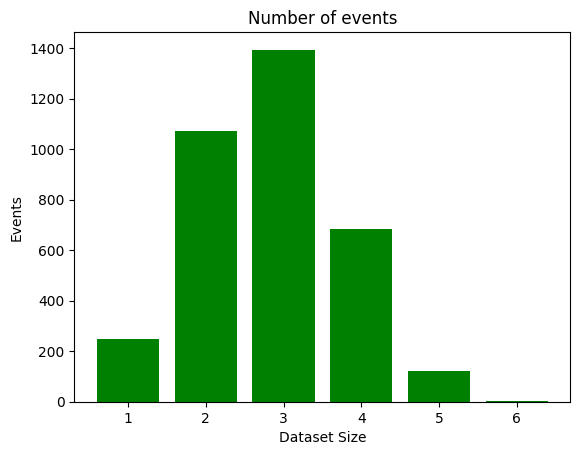

In [30]:
import matplotlib.pyplot as plt

pair_lengths = list(pair_counts.keys())
pair_frequency = list(pair_counts.values())

# Plot
plt.bar(pair_lengths, pair_frequency, color='green')
plt.xlabel('Dataset Size')
plt.ylabel('Events')
plt.title('Number of events')
plt.xticks(pair_lengths)
plt.show()

In [26]:

#analyze the time needed

import time

sample = rdd.sample(False, 0.15, seed = 20)
elapsed = []
frequent = []
count = sample.count()
threshold_ap = []
for t in range(3,9):
  start = time.time()
  threshold_perc = t*0.01
  threshold_ap.append(threshold_perc)
  frequent.append(list(apriori(sample, threshold_perc*count).collect()))
  end = time.time()
  interval = end - start
  elapsed.append(interval)

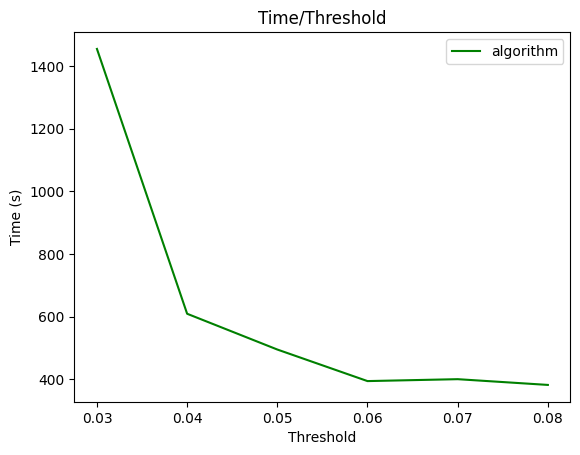

In [28]:
#apriori plot
import matplotlib.pyplot as plt

time_threshold_ratio = pd.DataFrame()
time_threshold_ratio['time'] = elapsed
time_threshold_ratio['Threshold'] = threshold_ap
plt.plot(time_threshold_ratio['Threshold'], time_threshold_ratio['time'],
         label = 'algorithm', color = 'green')
plt.xlabel('Threshold')
plt.ylabel('Time (s)')
plt.legend()
plt.title('Time/Threshold')
plt.show()

In [ ]:
import matplotlib.pyplot as plt # Import matplotlib.pyplot here
import seaborn as sns # Import seaborn as well

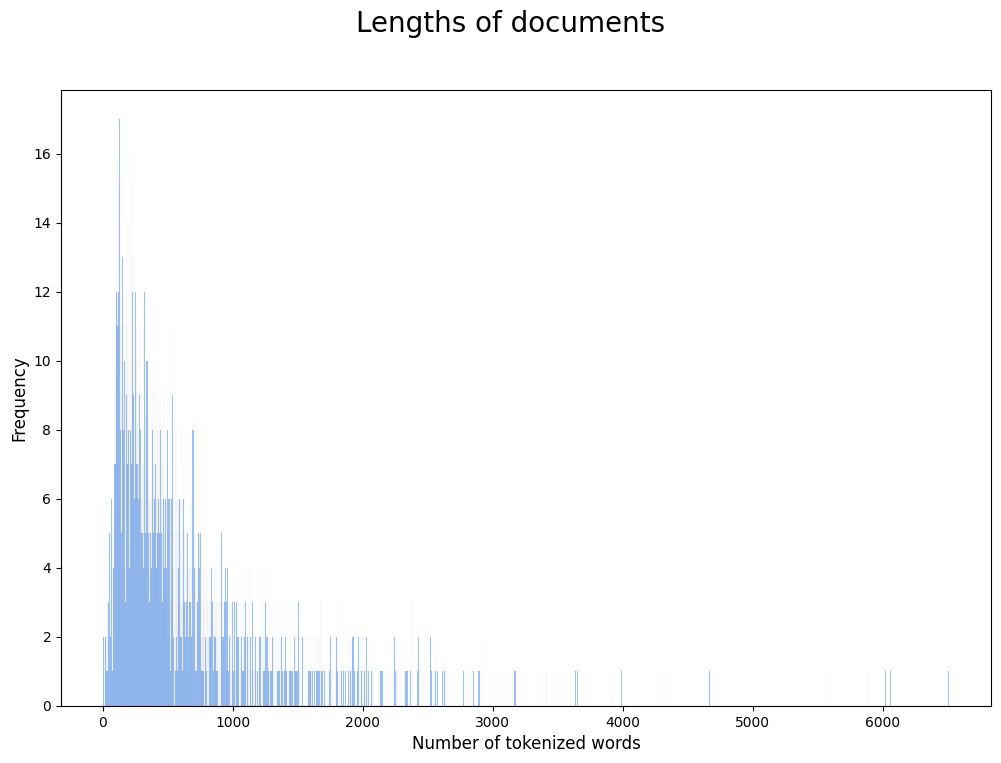

In [ ]:
# Plot the lengths of the tokenized documents
lengths = rdd.map(len).collect()

f, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=lengths, binwidth=2, ax=ax, color='#FFB27E')
ax.set_xlabel("Number of tokenized words", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
f.suptitle("Lengths of documents", fontsize=20)
plt.show()